# Part 0. Importing signal

First of all, let us import the signal:

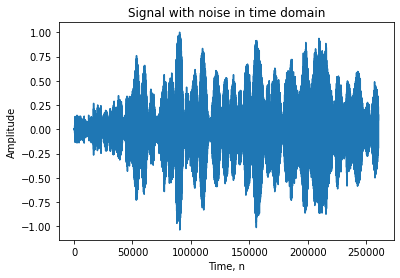

In [1]:
from scipy.io.wavfile import read as readwav
import matplotlib.pyplot as plt
# Read signal
Fs, signal = readwav("signal_with_noise.wav")
# Plot
plt.plot(signal)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Signal with noise in time domain")
plt.show()

Here is the frequency domain of the signal:

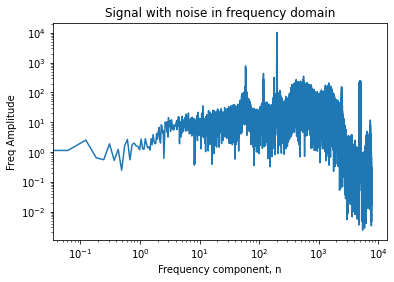

In [2]:
from matplotlib import pyplot as plt
from scipy.fft import fft
import numpy as np
# Plot spectrum
# Calculate frequencies
s_len = len(signal)
frequencies = np.arange(0,s_len)/s_len * Fs;
# Plot
plt.semilogy(frequencies[:s_len//2], abs(fft(signal))[:s_len//2])
plt.xlabel("Frequency component, n")
plt.ylabel("Freq Amplitude")
plt.title("Signal with noise in frequency domain")
plt.xscale('log')

# Part 1. Low-Pass Filter

The frequency response of the ideal low-pass filter $H(e^{j \omega})$ has rectangular form:
 \begin{equation} H(e^{j \omega}) = \begin{cases}
      1\text{,  if }|\omega | < cutoff\\
      0\text{ otherwise}
    \end{cases}
    \end{equation}
Where $\omega = 2 \pi f$. However, since the frequency is in range $[- \pi ; \pi]$, function $H$ is periodic, FFT is calculated with the assumption that we are in range $[0; 2\pi]$, we need to rewrite the equation the following way:
\begin{equation} H(e^{j \omega}) = \begin{cases}
      1\text{,  if }\omega \in [0; cutoff] \cup [2 \pi -cutoff; 2 \pi]\\
      0\text{ otherwise}
    \end{cases}
    \end{equation}

Then, let us design the lowpass filter. I will follow the tutorial provided in the task description:

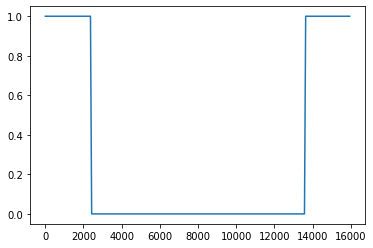

In [3]:
def ideal_lowpass(N, cutoff, stop_value):
    """
    N: integer length of FIR filter
    cutoff: fraction of Fs, at which frequencies are stopped
    stop_value: the value for frequencies in the stopband
    (after cutoff frequency)
    return: frequency representation of an ideal
    low pass FIR filter of length N+1 if N is even
    or N if N is odd
    """
    N = int((N - N % 2) / 2)
    cutoff = int(np.floor(2 * N * cutoff))
    H = np.ones((N,)) * stop_value
    H[:cutoff] = 1.
    # need to make N odd
    H = np.concatenate([np.ones((1,)), H, np.flip(H)]) # <---- line 16
    return H
# Plot ideal lowpass freq response
# Calculate lowpass
# Filter will have length 257
H_l = ideal_lowpass(256, 0.15, 0.);
# Calculate frequencies
h_len = len(H_l)
frequencies = np.arange(0,h_len)/h_len * Fs;
# Plot
plt.plot(frequencies, H_l)
plt.show()

It is sufficient in our case to take $0.15$ as the cutoff, since it iquals to $0.15 \cdot 16000 = 2400 Hz$ which is sufficient to filter out noise at $\approx 5000Hz$.

Calculating FFT we find the following signal:

Text(0.5, 1.0, 'Impulse response of ideal low-pass filter')

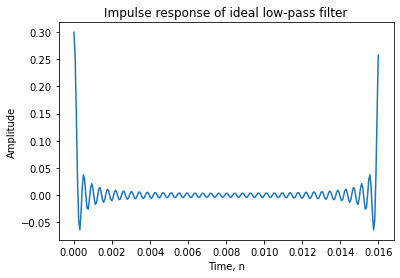

In [4]:
# Compute impulse response
# project into temporal domain
# imaginary part should be close to 0
h_l = np.real(np.fft.ifft(H_l))
plt.plot(np.arange(0,len(h_l))/Fs, h_l)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter")

But imaginary part of our filter equals to $0$. Such filters are not causal, in general. To address this problem we need to shif the signal in the time domain:

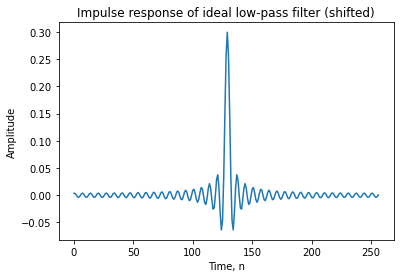

In [5]:
# Compute impulse response
# project into temporal domain
# imaginary part should be close to 0
h_ls = np.real(np.fft.ifftshift(h_l))
plt.plot(np.arange(0,len(h_ls)), h_ls)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter (shifted)")
plt.show()

The next thing we need to apply a window function because the signal does not converge to 0:

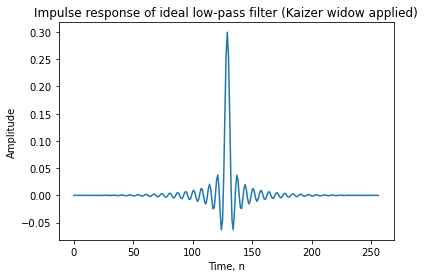

In [6]:
from scipy.signal import kaiser
h_lk = h_ls * kaiser(len(h_ls), 8)
plt.plot(np.arange(0,len(h_lk)), h_lk)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal low-pass filter (Kaizer widow applied)")
plt.show()

Finally, let us have a look at the resulting filter in the frequency domain:

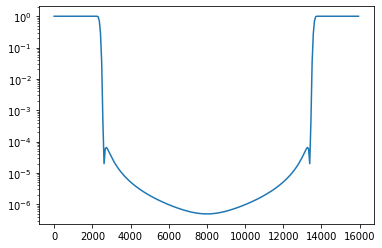

In [7]:
plt.semilogy(frequencies, abs(fft(h_lk)))
plt.show()

Applying the filter to the signal yields:

In [8]:
from scipy.signal import convolve
signal_f = convolve(signal, h_lk)

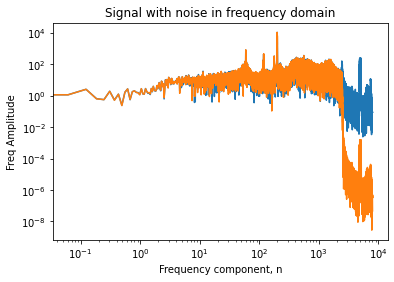

In [9]:
from matplotlib import pyplot as plt
from scipy.fft import fft
import numpy as np
# Plot spectrum
# Calculate frequencies
s_len = len(signal_f)
frequencies = np.arange(0,s_len)/s_len * Fs;
# Plot
plt.semilogy(frequencies[:s_len//2], abs(fft(signal))[:s_len//2])
plt.semilogy(frequencies[:s_len//2], abs(fft(signal_f))[:s_len//2])
plt.xlabel("Frequency component, n")
plt.ylabel("Freq Amplitude")
plt.title("Signal with noise in frequency domain")
plt.xscale('log')

Finally, let us listen to the recording:

In [10]:
from IPython.display import Audio
Audio(signal_f, rate=Fs)

# Part 2. Highpass filter design

The frequency response of the ideal high-pass filter $H(e^{j \omega})$ has rectangular form:
 \begin{equation} H(e^{j \omega}) = \begin{cases}
      1\text{,  if }|\omega |  > cutoff\\
      0\text{ otherwise}
    \end{cases}
    \end{equation}
Where $\omega = 2 \pi f$. However, since the frequency is in range $[- \pi ; \pi]$, function $H$ is periodic, FFT is calculated with the assumption that we are in range $[0; 2\pi]$, we need to rewrite the equation the following way:
\begin{equation} H(e^{j \omega}) = \begin{cases}
      1\text{,  if }\omega \in [cutoff; 2 \pi -cutoff]\\
      0\text{ otherwise}
    \end{cases}
    \end{equation}
    
Implementing the filter, we can immediately notice that the $hp=1-lp$, where $hp$ - highpass filter, $lp$ - lowpass filter. Since we also have stop value, the subtraction yields:
\begin{equation} H(e^{j \omega}) = \begin{cases}
      1- \text{stop_value}\text{,  if }\omega \in [cutoff; 2 \pi -cutoff]\\
      0\text{ otherwise}
    \end{cases}
\end{equation}
Therefore, we also need to compensate the stop_value in our implementation:
$$hp=1-lp + \text{stop_value}$$

In [11]:
def ideal_highpass(N, cutoff, stop_value):
    # Implementation of highpass filter presented above
    return 1-ideal_lowpass(N, cutoff, stop_value) + stop_value

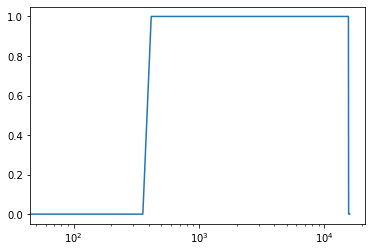

In [12]:
# Plot ideal highpass freq response
# Calculate highpasspass
# Filter will have length 269
H_h = ideal_highpass(269, 0.025, 0.);
# Calculate frequencies
h_len = len(H_h)
frequencies = np.arange(0,h_len)/h_len * Fs;
# Plot
plt.plot(frequencies, H_h)
plt.xscale('log')

Taking $cutoff=0.025$ is sufficient for highpass filter, since $freq_cutoff = 16000*0.025=400 Hz > \approx 200Hz$ as was stated in the task description

Next, we will repeat the same steps as in the Lowpass filter:

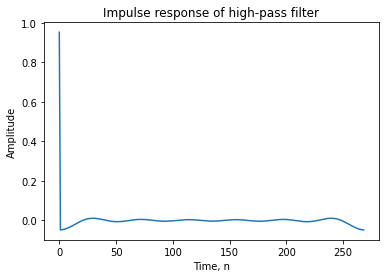

In [13]:
# Compute impulse response
# project into temporal domain
# imaginary part should be close to 0
h_h = np.real(np.fft.ifft(H_h))
plt.plot(np.arange(0,len(h_h)), h_h)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of high-pass filter")
plt.show()

Text(0.5, 1.0, 'Impulse response of high-pass filter (shifted)')

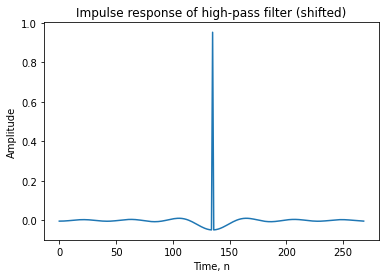

In [14]:
h_hs = np.real(np.fft.ifftshift(h_h))
plt.plot(np.arange(0,len(h_hs)), h_hs)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of high-pass filter (shifted)")

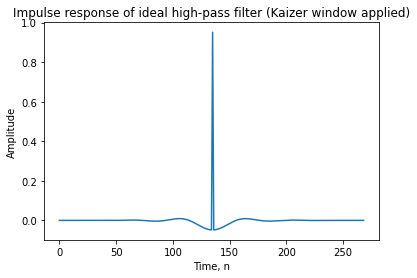

In [15]:
from scipy.signal import kaiser
h_hk = h_hs * kaiser(len(h_hs), 8)
plt.plot(np.arange(0,len(h_hk)), h_hk)
plt.xlabel("Time, n")
plt.ylabel("Amplitude")
plt.title("Impulse response of ideal high-pass filter (Kaizer window applied)")
plt.show()

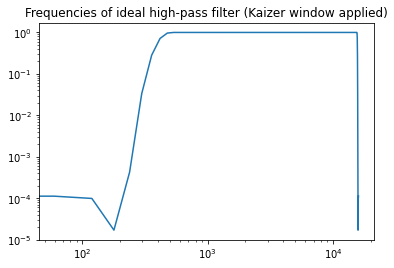

In [16]:
plt.semilogy(frequencies, abs(fft(h_hk)))
plt.xscale('log')
plt.title("Frequencies of ideal high-pass filter (Kaizer window applied)")
plt.show()

Applying filter to the low-pass filtered signal:

In [17]:
from scipy.signal import convolve
signal_ff = convolve(signal_f, h_hk)

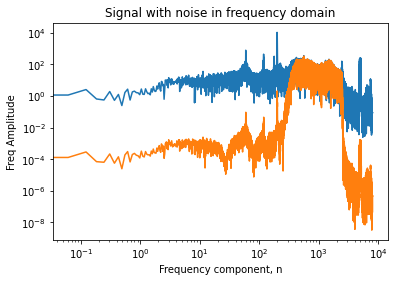

In [18]:
from matplotlib import pyplot as plt
from scipy.fft import fft
import numpy as np
# Plot spectrum
# Calculate frequencies
s_len = len(signal_ff)
frequencies = np.arange(0,s_len)/s_len * Fs;
# Plot
plt.semilogy(frequencies[:s_len//2], abs(fft(signal))[:s_len//2])
plt.semilogy(frequencies[:s_len//2], abs(fft(signal_ff))[:s_len//2])
plt.xlabel("Frequency component, n")
plt.ylabel("Freq Amplitude")
plt.title("Signal with noise in frequency domain")
plt.xscale('log')
plt.show()

As we can see from the graph, the noise has been filtered. Now let us listen to the original signal and the result:

### Original signal

In [19]:
Audio(signal, rate=Fs)

### Filtered signal

In [20]:
Audio(signal_ff, rate=Fs)